## Constrained clustering. Expectation Maximization Algorithm.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(8,4)})

## Initial data

In [2]:
points = pd.DataFrame({
    'x': [-3.5, -2.8, -2, -3, -1.2, 1, 2.5, 3, 3, 3.5],
    'y': [0.5, 0.4, 0, -.5, -0.5, 0.8, 1.2, 1.4, 1.3, -.5],
    'target': [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
})
points

,x,y,target
0,-3.5,0.5,1
1,-2.8,0.4,1
2,-2.0,0.0,1
3,-3.0,-0.5,1
4,-1.2,-0.5,1
5,1.0,0.8,0
6,2.5,1.2,0
7,3.0,1.4,0
8,3.0,1.3,0
9,3.5,-0.5,0


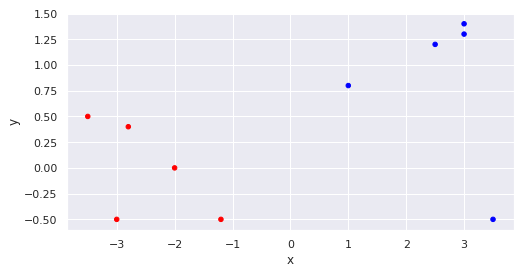

In [3]:
a = points.plot.scatter('x', 'y', c=points['target'].map({1: 'red', 0: 'blue'}))

## Means, MSEs, Covariance matrices

In [0]:
# mean vector for 1-class
mv1 = [points.x[points['target'] == 1].mean(), points.y[points['target'] == 1].mean()]

# mean vector for 0-class
mv0 = [points.x[points['target'] == 0].mean(), points.y[points['target'] == 0].mean()]

In [0]:
# MSE for 1-class
mse_x1 = sum(list(map(lambda x: (x-mv1[0])**2, points.x[points['target'] == 1]))) \
        /len(list(map(lambda x: (x-mv1[0])**2, points.x[points['target'] == 1])))
mse_y1 = sum(list(map(lambda y: (y-mv1[1])**2, points.y[points['target'] == 1]))) \
        /len(list(map(lambda y: (y-mv1[1])**2, points.y[points['target'] == 1])))

# MSE for 0-class
mse_x0 = sum(list(map(lambda x: (x-mv0[0])**2, points.x[points['target'] == 0]))) \
    /len(list(map(lambda x: (x-mv0[0])**2, points.x[points['target'] == 0])))
mse_y0 = sum(list(map(lambda y: (y-mv0[1])**2, points.y[points['target'] == 0]))) \
    /len(list(map(lambda y: (y-mv0[1])**2, points.y[points['target'] == 0])))

In [0]:
# covariance matrix for 1-class
mcov1 = np.matrix([
    [mse_x1, mse_y1*mse_x1],
    [mse_x1*mse_y1, mse_y1]
])

# covariance matrix for 0-class
mcov0 = np.matrix([
    [mse_x0**1, mse_y0*mse_x0],
    [mse_x0*mse_y0, mse_y0**1]
])

## Computing probability

In [0]:
def p_eval(mcov, mv, v):
    '''
    mcov: covariance matrix, np.matrix
    mv: mean vector, list
    v: point vector, list
    '''
    dim = 2
    det_mcov = float(np.linalg.det(mcov))
    mcov_inv = np.linalg.inv(mcov)
    x_mu = lambda x, mu: x - mu
    x_mu_t = lambda x, mu: (x - mu).T

    return (round((1/((2*round(np.pi,2)**(dim//2))*(det_mcov**0.5))) \
                                *np.exp(-0.5*x_mu_t(np.matrix(v).T,np.matrix(mv).T)\
                                        *mcov_inv \
                                        *x_mu(np.matrix(v).T,np.matrix(mv).T))[0,0],3))

In [8]:
# evaluating p for labelled points
for mcov, mv, b in [[mcov1, mv1, 1], [mcov0, mv0, 0]]:
    print()
    print('class',b)
    for row, col in points[points['target'] == b].iterrows():
        print(row, ':',p_eval(mcov, mv, [col.x, col.y]))


class 1
0 : 0.049
1 : 0.227
2 : 0.4
3 : 0.253
4 : 0.027

class 0
5 : 0.024
6 : 0.252
7 : 0.24
8 : 0.266
9 : 0.001


## K-Means clustering

In [9]:
# initial values for k-means
k = 2
mv_kmeans0 = [0,1]
mv_kmeans1 = [0,0]
J = 0

while True:
    dist_0 = pd.Series(list(map(lambda x,y: ((x - mv_kmeans0[0])**2 + (y - mv_kmeans0[1])**2)**0.5, points['x'], points['y'])))
    dist_1 = pd.Series(list(map(lambda x,y: ((x - mv_kmeans1[0])**2 + (y - mv_kmeans1[1])**2)**0.5, points['x'], points['y'])))
    
    points['class'] = list(map(
        lambda d0, d1: 0 if d0 < d1 else 1, dist_0, dist_1))
    
    mv_kmeans1 = [points['x'][points['class'] == 1].sum() / len(points['x'][points['class'] == 1]),
                  points['y'][points['class'] == 1].sum() / len(points['y'][points['class'] == 1])]
    mv_kmeans0 = [points['x'][points['class'] == 0].sum() / len(points['x'][points['class'] == 0]),
                  points['y'][points['class'] == 0].sum() / len(points['y'][points['class'] == 0])]
    
    
    J_new = sum(list(map(lambda x, y: min(x**2, y**2),
                         dist_0,
                         dist_1)))
    print("J = ", round(J_new,3))
    if abs(J - J_new) < 0.01:
        print("Converge!")
        print()
        print("Final centroids: ")
        print('Class 0: ', list(map(lambda x: round(x,2), mv_kmeans0)))
        print('Class 1: ', list(map(lambda x: round(x,2), mv_kmeans1)))
        break
    else:
        J = J_new

J =  73.52
J =  16.186
J =  10.34
J =  10.34
Converge!

Final centroids: 
Class 0:  [2.6, 0.84]
Class 1:  [-2.5, -0.02]


## Add two more points

#### Recalculate parameters once new point occurs


In [0]:
test_point1 = [-2, -1.5]
test_point2 = [3.2, 0]

In [0]:
points_1 = points[['x','y','target']].copy()

### Add 11th point

In [12]:
points_1 = points_1.append(pd.DataFrame({
    'x': [test_point1[0]],
    'y': [test_point1[1]],
    'target': [0 if p_eval(mcov=mcov0, mv=mv0, v=test_point1) > p_eval(mcov=mcov1, mv=mv1, v=test_point1) else 1]
    }, index=[max(points_1.index)+1])
)
points_1

,x,y,target
0,-3.5,0.5,1
1,-2.8,0.4,1
2,-2.0,0.0,1
3,-3.0,-0.5,1
4,-1.2,-0.5,1
5,1.0,0.8,0
6,2.5,1.2,0
7,3.0,1.4,0
8,3.0,1.3,0
9,3.5,-0.5,0


In [0]:
# mean vector for 1-class
mv1 = [points_1.x[points_1['target'] == 1].mean(), points_1.y[points_1['target'] == 1].mean()]

# mean vector for 0-class
mv0 = [points_1.x[points_1['target'] == 0].mean(), points_1.y[points_1['target'] == 0].mean()]

In [0]:
# MSE for 1-class
mse_x1 = sum(list(map(lambda x: (x-mv1[0])**2, points_1.x[points_1['target'] == 1]))) \
        /len(list(map(lambda x: (x-mv1[0])**2, points_1.x[points_1['target'] == 1])))
mse_y1 = sum(list(map(lambda y: (y-mv1[1])**2, points_1.y[points_1['target'] == 1]))) \
        /len(list(map(lambda y: (y-mv1[1])**2, points_1.y[points_1['target'] == 1])))

# MSE for 0-class
mse_x0 = sum(list(map(lambda x: (x-mv0[0])**2, points_1.x[points_1['target'] == 0]))) \
    /len(list(map(lambda x: (x-mv0[0])**2, points_1.x[points_1['target'] == 0])))
mse_y0 = sum(list(map(lambda y: (y-mv0[1])**2, points_1.y[points_1['target'] == 0]))) \
    /len(list(map(lambda y: (y-mv0[1])**2, points_1.y[points_1['target'] == 0])))

In [0]:
# covariance matrix for 1-class
mcov1 = np.matrix([
    [mse_x1, mse_y1*mse_x1],
    [mse_x1*mse_y1, mse_y1]
])

# covariance matrix for 0-class
mcov0 = np.matrix([
    [mse_x0**1, mse_y0*mse_x0],
    [mse_x0*mse_y0, mse_y0**1]
])

In [16]:
# evaluating p for labelled points
for mcov, mv, b in [[mcov1, mv1, 1], [mcov0, mv0, 0]]:
    print()
    print('class',b)
    for row, col in points_1[points_1['target'] == b].iterrows():
        print(row, ':', p_eval(mcov, mv, [col.x, col.y]))


class 1
0 : 0.012
1 : 0.111
2 : 0.308
3 : 0.269
4 : 0.04
10 : 0.015

class 0
5 : 0.024
6 : 0.252
7 : 0.24
8 : 0.266
9 : 0.001


### Add 12th point

In [17]:
points_1 = points_1.append(pd.DataFrame({
    'x': [test_point2[0]],
    'y': [test_point2[1]],
    'target': [0 if p_eval(mcov=mcov0, mv=mv0, v=test_point2) > p_eval(mcov=mcov1, mv=mv1, v=test_point2) else 1]
    }, index=[max(points_1.index)+1])
)
points_1

,x,y,target
0,-3.5,0.5,1
1,-2.8,0.4,1
2,-2.0,0.0,1
3,-3.0,-0.5,1
4,-1.2,-0.5,1
5,1.0,0.8,0
6,2.5,1.2,0
7,3.0,1.4,0
8,3.0,1.3,0
9,3.5,-0.5,0


In [0]:
# mean vector for 1-class
mv1 = [points_1.x[points_1['target'] == 1].mean(), points_1.y[points_1['target'] == 1].mean()]

# mean vector for 0-class
mv0 = [points_1.x[points_1['target'] == 0].mean(), points_1.y[points_1['target'] == 0].mean()]

In [0]:
# MSE for 1-class
mse_x1 = sum(list(map(lambda x: (x-mv1[0])**2, points_1.x[points_1['target'] == 1]))) \
        /len(list(map(lambda x: (x-mv1[0])**2, points_1.x[points_1['target'] == 1])))
mse_y1 = sum(list(map(lambda y: (y-mv1[1])**2, points_1.y[points_1['target'] == 1]))) \
        /len(list(map(lambda y: (y-mv1[1])**2, points_1.y[points_1['target'] == 1])))

# MSE for 0-class
mse_x0 = sum(list(map(lambda x: (x-mv0[0])**2, points_1.x[points_1['target'] == 0]))) \
    /len(list(map(lambda x: (x-mv0[0])**2, points_1.x[points_1['target'] == 0])))
mse_y0 = sum(list(map(lambda y: (y-mv0[1])**2, points_1.y[points_1['target'] == 0]))) \
    /len(list(map(lambda y: (y-mv0[1])**2, points_1.y[points_1['target'] == 0])))

In [0]:
# covariance matrix for 1-class
mcov1 = np.matrix([
    [mse_x1, mse_y1*mse_x1],
    [mse_x1*mse_y1, mse_y1]
])

# covariance matrix for 0-class
mcov0 = np.matrix([
    [mse_x0**1, mse_y0*mse_x0],
    [mse_x0*mse_y0, mse_y0**1]
])

In [21]:
# evaluating p for labelled points
for mcov, mv, b in [[mcov1, mv1, 1], [mcov0, mv0, 0]]:
    print()
    print('class',b)
    for row, col in points_1[points_1['target'] == b].iterrows():
        print(row, ":", p_eval(mcov, mv, [col.x, col.y]))


class 1
0 : 0.012
1 : 0.111
2 : 0.308
3 : 0.269
4 : 0.04
10 : 0.015

class 0
5 : 0.01
6 : 0.191
7 : 0.201
8 : 0.233
9 : 0.004
11 : 0.072


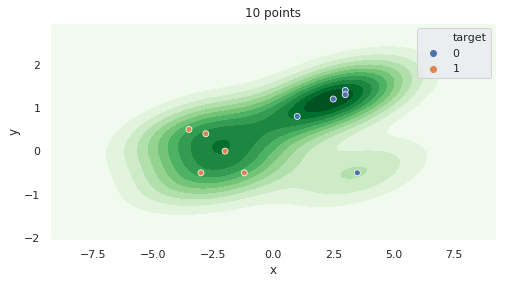

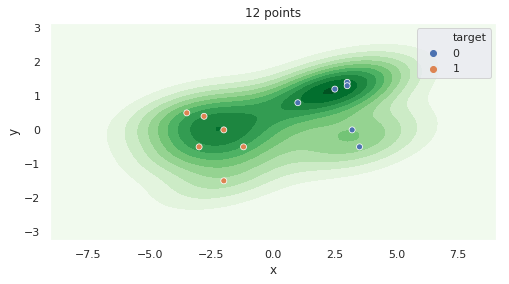

In [22]:
# 10 points plot
sns.kdeplot(points['x'], points['y'], cmap="Greens", shade=True, shade_lowest=True, kernel='gau');
sns.scatterplot(points['x'], points['y'], hue=points['target']);
plt.title('10 points')
plt.show()
# 12 points plot
plt.title('12 points')
sns.kdeplot(points_1['x'], points_1['y'], cmap="Greens", shade=True, shade_lowest=True, kernel='gau');
sns.scatterplot(points_1['x'], points_1['y'], hue=points_1['target']);

## Density plots

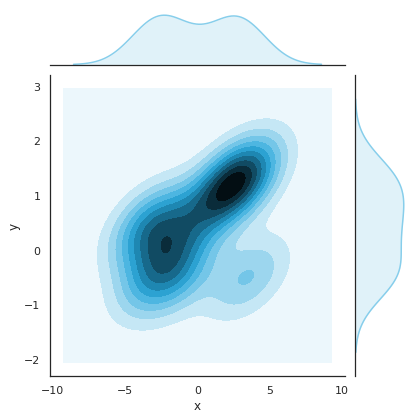

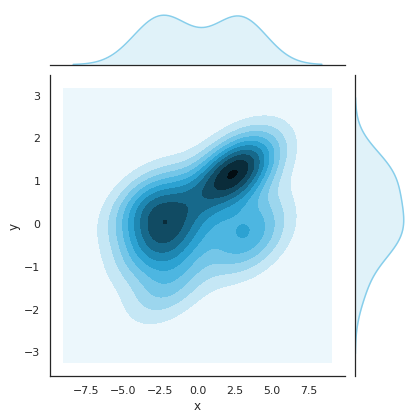

In [23]:
sns.set(style="white", color_codes=True)
sns.jointplot(x=points['x'], y=points['y'], kind='kde', color="skyblue");
sns.jointplot(x=points_1['x'], y=points_1['y'], kind='kde', color="skyblue");